# 获取数据

In [27]:
import  configparser
config = configparser.ConfigParser()
config.read('../config.ini')
token = config.get('tushare', 'token')

import tushare as ts
ts.set_token(token)

In [28]:
origin_daily_300 = ts.pro_bar(ts_code='000300.SH', asset='I').sort_values('trade_date').reset_index()
daily_300 = origin_daily_300.copy()
daily_300

,index,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,amount
0,4145,000300.SH,20050104,982.7940,994.7690,994.7690,980.6580,1000.0000,-17.2060,-1.7206,7.412869e+06,4.431977e+06
1,4144,000300.SH,20050105,992.5640,981.5770,997.3230,979.8770,982.7940,9.7700,0.9941,7.119109e+06,4.529208e+06
2,4143,000300.SH,20050106,983.1740,993.3310,993.7880,980.3300,992.5640,-9.3900,-0.9460,6.288029e+06,3.921015e+06
3,4142,000300.SH,20050107,983.9580,983.0450,995.7110,979.8120,983.1740,0.7840,0.0797,7.298694e+06,4.737469e+06
4,4141,000300.SH,20050110,993.8790,983.7600,993.9590,979.7890,983.9580,9.9210,1.0083,5.791698e+06,3.762933e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
4141,4,000300.SH,20220117,4767.2762,4728.7595,4775.2385,4726.7083,4726.7317,40.5445,0.8578,1.152957e+08,2.637882e+08
4142,3,000300.SH,20220118,4813.3472,4766.7811,4826.3003,4747.9200,4767.2762,46.0710,0.9664,1.508708e+08,2.827494e+08
4143,2,000300.SH,20220119,4780.3784,4815.8106,4828.7522,4755.9301,4813.3472,-32.9688,-0.6849,1.339274e+08,2.755346e+08
4144,1,000300.SH,20220120,4823.5091,4778.2616,4845.0048,4777.5683,4780.3784,43.1307,0.9022,1.649713e+08,3.043443e+08


# 计算指标
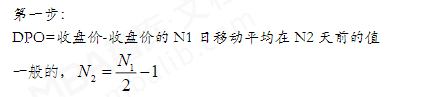
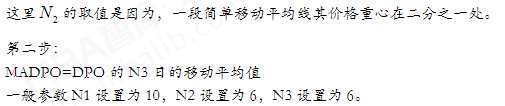

In [48]:
import pandas_ta as ta
import numpy as np
import pandas as pd

In [49]:
pd.DataFrame().ta.indicators()

Pandas TA - Technical Analysis Indicators - v0.3.14b0
Total Indicators & Utilities: 205
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, alma, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl_pattern, cdl_z, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, cti, decay, decreasing, dema, dm, donchian, dpo, ebsw, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, hwc, hwma, ichimoku, increasing, inertia, jma, kama, kc, kdj, kst, kurtosis, kvo, linreg, log_return, long_run, macd, mad, massi, mcgd, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvr, pvt, pwma, qqe, qstick, quantile, rma, roc, rsi, rsx, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, squeeze_pro, ssf, stc, stdev, stoch, stochrsi, supertrend, swma, t3, td_seq, tema, thermo, tos_stdevall, trima, trix, true_range, tsi, tsignals, ttm_trend, ui, 

In [50]:
def calc_DPO(mkt_data, N1=10, N2=None, N3=6):
    close = mkt_data['close']
    """ 指标计算 """
    #DPO = ta.dpo(close, length=N1)
    if not N2:
        N2 = N1//2 + 1
    DPO = close - close.rolling(N1).mean().shift(N2)
    MADPO = DPO.rolling(N3).mean()
    """ 指标赋值 """
    mkt_data['DPO'] = DPO
    mkt_data['MADPO'] = MADPO
    return mkt_data

# 计算信号
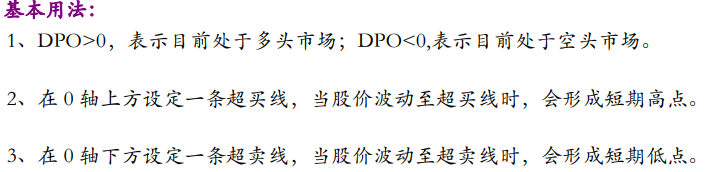

In [52]:
def calc_signal(mkt_data):
    DPO = mkt_data['DPO'] 
    MADPO = mkt_data['MADPO']
    """ 计算信号 """
    signals = []
    for dpo, madpo in zip(DPO, MADPO):
        signal = None
        if dpo>=0:
            signal = 1
        else:
            signal = -1
        signals.append(signal)
    """ 赋值 """
    mkt_data['signal'] = signals
    return mkt_data

# 计算持仓

In [53]:
def calc_position(mkt_data):
    mkt_data['position'] = mkt_data['signal'].fillna(method='ffill').shift(1).fillna(0)
    return mkt_data

# 计算结果

In [54]:
def statistic_performance(mkt_data, r0=0.03, data_period=1440):
    position = mkt_data['position']
    
    """      序列型特征 
        hold_r :      持仓收益
        hold_win :    持仓胜负
        hold_cumu_r : 累计持仓收益
        drawdown :    回撤
        ex_hold_r :   超额收益
    """
    hold_r = mkt_data['pct_chg']/100 * position
    hold_win = hold_r>0
    hold_cumu_r = (1+hold_r).cumprod() - 1
    drawdown = (hold_cumu_r.cummax()-hold_cumu_r)/(1+hold_cumu_r).cummax()    
    ex_hold_r= hold_r-r0/(250*1440/data_period)

    mkt_data['hold_r'] = hold_r
    mkt_data['hold_win'] = hold_win
    mkt_data['hold_cumu_r'] = hold_cumu_r
    mkt_data['drawdown'] = drawdown
    mkt_data['ex_hold_r'] = ex_hold_r
    
    """       数值型特征 
        v_hold_cumu_r：         累计持仓收益
        v_pos_hold_times：      多仓开仓次数
        v_pos_hold_win_times：  多仓开仓盈利次数
        v_pos_hold_period：     多仓持有周期数
        v_pos_hold_win_period： 多仓持有盈利周期数
        v_neg_hold_times：      空仓开仓次数
        v_neg_hold_win_times：  空仓开仓盈利次数
        v_neg_hold_period：     空仓持有盈利周期数
        v_neg_hold_win_period： 空仓开仓次数
        v_hold_period：         持仓周期数（最后一笔未平仓订单也算）
        v_hold_win_period：     持仓盈利周期数（最后一笔未平仓订单也算）
        v_max_dd：              最大回撤
        v_annual_std：          年化标准差
        v_annual_ret：          年化收益
        v_sharpe：              夏普率
    """
    v_hold_cumu_r = hold_cumu_r.tolist()[-1]

    v_pos_hold_times= 0 
    v_pos_hold_win_times = 0
    v_pos_hold_period = 0
    v_pos_hold_win_period = 0
    v_neg_hold_times= 0 
    v_neg_hold_win_times = 0
    v_neg_hold_period = 0
    v_neg_hold_win_period = 0
    for w, r, pre_pos, pos in zip(hold_win, hold_r, position.shift(1), position):
        # 有换仓（先结算上一次持仓，再初始化本次持仓）
        if pre_pos!=pos: 
            # 判断pre_pos非空：若为空则是循环的第一次，此时无需结算，直接初始化持仓即可
            if pre_pos == pre_pos:
                # 结算上一次持仓
                if pre_pos>0:
                    v_pos_hold_times += 1
                    v_pos_hold_period += tmp_hold_period
                    v_pos_hold_win_period += tmp_hold_win_period
                    if tmp_hold_r>0:
                        v_pos_hold_win_times+=1
                elif pre_pos<0:
                    v_neg_hold_times += 1      
                    v_neg_hold_period += tmp_hold_period
                    v_neg_hold_win_period += tmp_hold_win_period
                    if tmp_hold_r>0:                    
                        v_neg_hold_win_times+=1
            # 初始化本次持仓
            tmp_hold_r = r
            tmp_hold_period = 0
            tmp_hold_win_period = 0
        else: # 未换仓
            if abs(pos)>0:
                tmp_hold_period += 1
                if r>0:
                    tmp_hold_win_period += 1
                if abs(r)>0:
                    tmp_hold_r = (1+tmp_hold_r)*(1+r)-1       

    v_hold_period = (abs(position)>0).sum()
    v_hold_win_period = (hold_r>0).sum()
    v_max_dd = drawdown.max()    
    v_annual_ret = pow( 1+v_hold_cumu_r, 
                      1/(data_period/1440*len(mkt_data)/250) )-1
    v_annual_std = ex_hold_r.std() * np.sqrt(250*1440/data_period) 
    v_sharpe= v_annual_ret / v_annual_std

    """ 生成Performance DataFrame """
    performance_cols = ['累计收益', 
                        '多仓次数', '多仓胜率', '多仓平均持有期', 
                        '空仓次数', '空仓胜率', '空仓平均持有期', 
                        '日胜率', '最大回撤', '年化收益/最大回撤',
                        '年化收益', '年化标准差', '年化夏普'
                       ]
    performance_values = ['{:.2%}'.format(v_hold_cumu_r),
                          v_pos_hold_times, '{:.2%}'.format(v_pos_hold_win_times/v_pos_hold_times), 
                                            '{:.2f}'.format(v_pos_hold_period/v_pos_hold_times),
                          v_neg_hold_times, '{:.2%}'.format(v_neg_hold_win_times/v_neg_hold_times), 
                                            '{:.2f}'.format(v_neg_hold_period/v_neg_hold_times),
                          '{:.2%}'.format(v_hold_win_period/v_hold_period), 
                          '{:.2%}'.format(v_max_dd), 
                          '{:.2f}'.format(v_annual_ret/v_max_dd),
                          '{:.2%}'.format(v_annual_ret), 
                          '{:.2%}'.format(v_annual_std), 
                          '{:.2f}'.format(v_sharpe)
                         ]
    performance_df = pd.DataFrame(performance_values, index=performance_cols)
    return mkt_data, performance_df

# 可视化结果

In [55]:
import datetime
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import column, row, gridplot, layout
from bokeh.models import Span
output_notebook()

Loading BokehJS ...

In [56]:
def visualize_performance(mkt_data):
    mkt_data['trade_datetime'] = mkt_data['trade_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y%m%d'))
    dt = mkt_data['trade_datetime']

    f1 = figure(height=300, width=700, 
                sizing_mode='stretch_width', 
                title='Target Trend',
                x_axis_type='datetime',
                x_axis_label="trade_datetime", y_axis_label="close")
    f2 = figure(height=200, sizing_mode='stretch_width', 
                title='Position',
                x_axis_label="trade_datetime", y_axis_label="position",
                x_axis_type='datetime',
                x_range=f1.x_range)
    f3 = figure(height=200, sizing_mode='stretch_width', 
                title='Return',
                x_axis_type='datetime',
                x_range=f1.x_range)
    f4 = figure(height=200, sizing_mode='stretch_width', 
                title='Drawdown',
                x_axis_type='datetime',
                x_range=f1.x_range)

    indi = figure(height=200, sizing_mode='stretch_width', 
                  title='KDJ',
                  x_axis_type='datetime',
                  x_range=f1.x_range
                 )

    # 绘制行情
    close = mkt_data['close']
    cumu_hold_close = (mkt_data['hold_cumu_r']+1)
    f1.line(dt, close/close.tolist()[0], line_width=1)
    f1.line(dt, cumu_hold_close, line_width=1, color='red')

    # 绘制指标
    

    # 绘制仓位
    position = mkt_data['position']
    f2.step(dt, position)

    # 绘制收益
    hold_r = mkt_data['hold_r']
    f3.vbar(x=dt, top=hold_r)

    # 绘制回撤
    drawdown = mkt_data['drawdown']
    f4.line(dt, -drawdown, line_width=1)

    #p = column(f1,f2,f3,f4)
    p = gridplot([ [f1],
                   # [indi],
                   [f2], 
                   [f3],
                   [f4]
                 ])
    show(p)

# 整体运行

In [57]:
daily_300 = calc_DPO(daily_300, N1=12, N3=6)
daily_300 = calc_signal(daily_300)
daily_300 = calc_position(daily_300)
daily_300

,index,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,amount,DPO,MADPO,signal,position
0,4145,000300.SH,20050104,982.7940,994.7690,994.7690,980.6580,1000.0000,-17.2060,-1.7206,7.412869e+06,4.431977e+06,NaN,NaN,-1,0.0
1,4144,000300.SH,20050105,992.5640,981.5770,997.3230,979.8770,982.7940,9.7700,0.9941,7.119109e+06,4.529208e+06,NaN,NaN,-1,-1.0
2,4143,000300.SH,20050106,983.1740,993.3310,993.7880,980.3300,992.5640,-9.3900,-0.9460,6.288029e+06,3.921015e+06,NaN,NaN,-1,-1.0
3,4142,000300.SH,20050107,983.9580,983.0450,995.7110,979.8120,983.1740,0.7840,0.0797,7.298694e+06,4.737469e+06,NaN,NaN,-1,-1.0
4,4141,000300.SH,20050110,993.8790,983.7600,993.9590,979.7890,983.9580,9.9210,1.0083,5.791698e+06,3.762933e+06,NaN,NaN,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4141,4,000300.SH,20220117,4767.2762,4728.7595,4775.2385,4726.7083,4726.7317,40.5445,0.8578,1.152957e+08,2.637882e+08,-142.956600,-136.617989,-1,-1.0
4142,3,000300.SH,20220118,4813.3472,4766.7811,4826.3003,4747.9200,4767.2762,46.0710,0.9664,1.508708e+08,2.827494e+08,-89.292567,-134.086818,-1,-1.0
4143,2,000300.SH,20220119,4780.3784,4815.8106,4828.7522,4755.9301,4813.3472,-32.9688,-0.6849,1.339274e+08,2.755346e+08,-116.393925,-130.140946,-1,-1.0
4144,1,000300.SH,20220120,4823.5091,4778.2616,4845.0048,4777.5683,4780.3784,43.1307,0.9022,1.649713e+08,3.043443e+08,-60.682775,-125.787496,-1,-1.0


In [58]:
# 评价和展现
#result_daily_300, performance_df = statistic_performance(daily_300)
#result_daily_300, performance_df = statistic_performance(daily_300[daily_300['trade_date'].apply(lambda x: x>='20050901' and x<='20120315')])
result_daily_300, performance_df = statistic_performance(daily_300[daily_300['trade_date'].apply(lambda x: x>='20120315')])

visualize_performance(result_daily_300)
print(performance_df)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

                 0
累计收益       -27.65%
多仓次数           120
多仓胜率        30.00%
多仓平均持有期      10.07
空仓次数           120
空仓胜率        23.33%
空仓平均持有期       7.77
日胜率         48.85%
最大回撤        59.36%
年化收益/最大回撤    -0.06
年化收益        -3.32%
年化标准差       22.52%
年化夏普         -0.15


# 策略优化

## 策略二
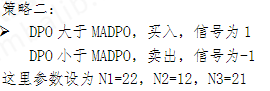

In [59]:
def calc_signal(mkt_data):
    DPO = mkt_data['DPO'] 
    MADPO = mkt_data['MADPO']
    """ 计算信号 """
    signals = []
    for dpo, madpo in zip(DPO, MADPO):
        signal = None
        if dpo>madpo:
            signal = 1
        else:
            signal = -1
        signals.append(signal)
    """ 赋值 """
    mkt_data['signal'] = signals
    return mkt_data

In [60]:
daily_300 = calc_DPO(daily_300, N1=22, N3=21)
daily_300 = calc_signal(daily_300)
daily_300 = calc_position(daily_300)
daily_300

,index,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,amount,DPO,MADPO,signal,position
0,4145,000300.SH,20050104,982.7940,994.7690,994.7690,980.6580,1000.0000,-17.2060,-1.7206,7.412869e+06,4.431977e+06,NaN,NaN,-1,0.0
1,4144,000300.SH,20050105,992.5640,981.5770,997.3230,979.8770,982.7940,9.7700,0.9941,7.119109e+06,4.529208e+06,NaN,NaN,-1,-1.0
2,4143,000300.SH,20050106,983.1740,993.3310,993.7880,980.3300,992.5640,-9.3900,-0.9460,6.288029e+06,3.921015e+06,NaN,NaN,-1,-1.0
3,4142,000300.SH,20050107,983.9580,983.0450,995.7110,979.8120,983.1740,0.7840,0.0797,7.298694e+06,4.737469e+06,NaN,NaN,-1,-1.0
4,4141,000300.SH,20050110,993.8790,983.7600,993.9590,979.7890,983.9580,9.9210,1.0083,5.791698e+06,3.762933e+06,NaN,NaN,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4141,4,000300.SH,20220117,4767.2762,4728.7595,4775.2385,4726.7083,4726.7317,40.5445,0.8578,1.152957e+08,2.637882e+08,-180.160800,-41.289148,-1,-1.0
4142,3,000300.SH,20220118,4813.3472,4766.7811,4826.3003,4747.9200,4767.2762,46.0710,0.9664,1.508708e+08,2.827494e+08,-138.157295,-52.032848,-1,-1.0
4143,2,000300.SH,20220119,4780.3784,4815.8106,4828.7522,4755.9301,4813.3472,-32.9688,-0.6849,1.339274e+08,2.755346e+08,-175.513473,-60.979995,-1,-1.0
4144,1,000300.SH,20220120,4823.5091,4778.2616,4845.0048,4777.5683,4780.3784,43.1307,0.9022,1.649713e+08,3.043443e+08,-135.182877,-69.408324,-1,-1.0


In [62]:
# 评价和展现
#result_daily_300, performance_df = statistic_performance(daily_300)
#result_daily_300, performance_df = statistic_performance(daily_300[daily_300['trade_date'].apply(lambda x: x>='20050901' and x<='20120315')])
result_daily_300, performance_df = statistic_performance(daily_300[daily_300['trade_date'].apply(lambda x: x>='20120315')])

visualize_performance(result_daily_300)
print(performance_df)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

                0
累计收益        2.98%
多仓次数          121
多仓胜率       27.27%
多仓平均持有期      9.16
空仓次数          121
空仓胜率       22.31%
空仓平均持有期      8.51
日胜率        48.90%
最大回撤       54.70%
年化收益/最大回撤    0.01
年化收益        0.31%
年化标准差      22.52%
年化夏普         0.01


## 策略三
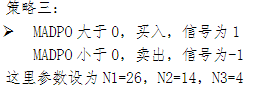

In [63]:
def calc_signal(mkt_data):
    DPO = mkt_data['DPO'] 
    MADPO = mkt_data['MADPO']
    """ 计算信号 """
    signals = []
    for dpo, madpo in zip(DPO, MADPO):
        signal = None
        if madpo>0:
            signal = 1
        else:
            signal = -1
        signals.append(signal)
    """ 赋值 """
    mkt_data['signal'] = signals
    return mkt_data

In [64]:
daily_300 = calc_DPO(daily_300, N1=26, N3=4)
daily_300 = calc_signal(daily_300)
daily_300 = calc_position(daily_300)
daily_300

,index,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,amount,DPO,MADPO,signal,position
0,4145,000300.SH,20050104,982.7940,994.7690,994.7690,980.6580,1000.0000,-17.2060,-1.7206,7.412869e+06,4.431977e+06,NaN,NaN,-1,0.0
1,4144,000300.SH,20050105,992.5640,981.5770,997.3230,979.8770,982.7940,9.7700,0.9941,7.119109e+06,4.529208e+06,NaN,NaN,-1,-1.0
2,4143,000300.SH,20050106,983.1740,993.3310,993.7880,980.3300,992.5640,-9.3900,-0.9460,6.288029e+06,3.921015e+06,NaN,NaN,-1,-1.0
3,4142,000300.SH,20050107,983.9580,983.0450,995.7110,979.8120,983.1740,0.7840,0.0797,7.298694e+06,4.737469e+06,NaN,NaN,-1,-1.0
4,4141,000300.SH,20050110,993.8790,983.7600,993.9590,979.7890,983.9580,9.9210,1.0083,5.791698e+06,3.762933e+06,NaN,NaN,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4141,4,000300.SH,20220117,4767.2762,4728.7595,4775.2385,4726.7083,4726.7317,40.5445,0.8578,1.152957e+08,2.637882e+08,-169.437758,-157.277569,-1,-1.0
4142,3,000300.SH,20220118,4813.3472,4766.7811,4826.3003,4747.9200,4767.2762,46.0710,0.9664,1.508708e+08,2.827494e+08,-125.042350,-167.446431,-1,-1.0
4143,2,000300.SH,20220119,4780.3784,4815.8106,4828.7522,4755.9301,4813.3472,-32.9688,-0.6849,1.339274e+08,2.755346e+08,-156.862485,-165.049806,-1,-1.0
4144,1,000300.SH,20220120,4823.5091,4778.2616,4845.0048,4777.5683,4780.3784,43.1307,0.9022,1.649713e+08,3.043443e+08,-113.918438,-141.315258,-1,-1.0


In [65]:
# 评价和展现
#result_daily_300, performance_df = statistic_performance(daily_300)
#result_daily_300, performance_df = statistic_performance(daily_300[daily_300['trade_date'].apply(lambda x: x>='20050901' and x<='20120315')])
result_daily_300, performance_df = statistic_performance(daily_300[daily_300['trade_date'].apply(lambda x: x>='20120315')])

visualize_performance(result_daily_300)
print(performance_df)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

                0
累计收益        1.43%
多仓次数           46
多仓胜率       30.43%
多仓平均持有期     27.57
空仓次数           45
空仓胜率       24.44%
空仓平均持有期     22.87
日胜率        50.60%
最大回撤       50.61%
年化收益/最大回撤    0.00
年化收益        0.15%
年化标准差      22.52%
年化夏普         0.01
